In [1]:
from sklearn.model_selection import train_test_split
import numpy as np
import math
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical

In [2]:
device = torch.device("cuda")

# Preprocessing

In [3]:
f = open("data/shakespear_dataset.txt", "r")
text = f.read()

data_size = len(text)

dictionary = []
for i in text:
    if i not in dictionary:
        dictionary.append(i)
#print(dictionary)

chunk_len = 100
print()
dataset = []
k = 0
for char in text:
    ind = [dictionary.index(char)]
    dataset.append(ind)

dataset = torch.tensor(dataset).to(device)
# for i in range(math.floor(len(text)/chunk_len)):
#     word = []
#     for j in range(k,k+chunk_len):
#         word.append(text[j])
#     k += chunk_len
#     dataset.append(word)
#dataset = text.split()
#print(dataset)


In [4]:
print(dictionary)

['F', 'i', 'r', 's', 't', ' ', 'C', 'z', 'e', 'n', ':', '\n', 'B', 'f', 'o', 'w', 'p', 'c', 'd', 'a', 'y', 'u', 'h', ',', 'm', 'k', '.', 'A', 'l', 'S', 'Y', 'v', '?', 'R', 'M', 'W', "'", 'L', 'I', 'N', 'g', ';', 'b', '!', 'O', 'j', 'V', '-', 'T', 'H', 'E', 'U', 'D', 'P', 'q', 'x', 'J', 'G', 'K', 'Q', '&', 'Z', 'X', '3']


In [5]:
print(dataset[0:10])

tensor([[0],
        [1],
        [2],
        [3],
        [4],
        [5],
        [6],
        [1],
        [4],
        [1]], device='cuda:0')


In [6]:
# def charIndex(x):
#     i = 0
#     for k in dictionary:
#         if x == k:
#             return i
#         else:
#             i += 1

# def one_hot(character):
#     identity = np.identity(len(dictionary))
#     i = charIndex(character)
#     one_h = identity[i]
#     return np.array(one_h)

In [7]:
# x = []
# y = []
# for xe in dataset:
#     ind = len(xe)
#     y_word = xe[1:]
    
#     x_word = xe[:ind-1]
#     x_embedd = []
#     y_embedd = []
#     for xc, yc in zip(x_word, y_word):
#         i = dictionary.index(xc)
#         x_embedd.append(i)
#         i = dictionary.index(yc)
#         y_embedd.append(i)
#     x.append(np.array(x_embedd))
#     y.append(np.array(y_embedd))
# x = np.array(x)
# y = np.array(y)
# print("First word in x:")
# print(x[0])
# print("First word in y:")
# print(y[0])

In [8]:
#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5, train_size=0.5, random_state=None, shuffle=False, stratify=None)

#x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.4, train_size=0.6, random_state=None, shuffle=False, stratify=None)

In [9]:
# print(x_train.shape)
# print(x_val.shape)
# print(x_test.shape)

# Model

In [10]:
########### Hyperparameters ###########
hidden_size = 200   # size of hidden state
seq_len = 100       # length of LSTM sequence
num_layers = 3      # num of layers in LSTM layer stack
learning_rate = 0.001          # learning rate
weight_decay = 1e-5            #weight decay
epochs = 200        # max number of epochs
drop_prob = 0.5
vocab_size = len(dictionary)  #length pf dictionary

In [11]:
from torch.autograd import Variable
class CharRNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers, drop_prob):
        super(CharRNN, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        
        self.embedding = nn.Embedding(input_size, input_size)
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers)
        #self.drop_out = nn.Dropout(drop_prob)
        self.fc = nn.Linear(hidden_size, output_size)
        
    
    def forward(self, x, hidden_state):
        embedds = self.embedding(x)
        out, hidden_state = self.lstm(embedds, hidden_state)
        #out = self.drop_out(out)
        out = self.fc(out)
        return out, (hidden_state[0].detach(), hidden_state[1].detach())
    
    def initHidden(self, batch_size):
        return (Variable(torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)),
                    Variable(torch.zeros(self.num_layers, batch_size, self.hidden_size)).to(device))

# Training

In [12]:
charRnn = CharRNN(vocab_size, vocab_size, hidden_size, num_layers, drop_prob)
charRnn = charRnn.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(charRnn.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [13]:
total_train_loss = []
loss = 0
for i in range(epochs):
    train_loss = 0
    n=0
    data_ptr = np.random.randint(100)
    while True:
        hidden_state = charRnn.initHidden(1)
        input_sequence = dataset[data_ptr:data_ptr+seq_len]
        target_sequence = dataset[data_ptr+1:data_ptr+seq_len+1]
        
        out, hidden_state = charRnn(input_sequence, hidden_state)
        
        loss = criterion(torch.squeeze(out), torch.squeeze(target_sequence))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        data_ptr += seq_len
        n += 1
        
        print(f"Epoch [{i+1}]/[{epochs}] loss: {loss.item()}", end="\r", flush=True)
        
        if data_ptr + seq_len + 1 > data_size:
            break
    total_train_loss.append(train_loss/n)
    print(f"Epoch loss: {train_loss/n}")
    print("-----------------------------------------------------------------")
    
    hidden_state = charRnn.initHidden(1)
    rand_index = np.random.randint(data_size-1)
    input_sequence = dataset[rand_index : rand_index+1]
    for i in range(100):
        out, hidden_state = charRnn(input_sequence, hidden_state)
        
        # construct categorical distribution and sample a character
        out = F.softmax(torch.squeeze(out), dim=0)
        dist = Categorical(out)
        index = dist.sample()
        
        print(dictionary[index.item()], end="")
        
        input_sequence[0][0] = index.item()
    print("\n-----------------------------------------------------------------\n")
    

Epoch loss: 1.79236666675405839631347656
-----------------------------------------------------------------
ich-bathing up, good but you, ilgeN, out
As 'traelhed do alrove should
would should show'd mennish! 
-----------------------------------------------------------------

Epoch loss: 1.48426003137276561209182748
-----------------------------------------------------------------
istority;--

GONZALO:
What you know my wrices-watch.

SEBASTIAN:

ANTONIO:
Who cause yourself.

GONZ
-----------------------------------------------------------------

Epoch loss: 1.40807471637243566351852417
-----------------------------------------------------------------
-withed without vice of upon the foul more;
To't I our talk me.

ALONSO:

SEBASTIAN:
Foul things not
-----------------------------------------------------------------

Epoch loss: 1.36846380051722533068847656
-----------------------------------------------------------------
roaz me kind or commend
cut to-morrow, gentling at awake; trall of l

No courthal
-----------------------------------------------------------------

Epoch loss: 1.207164393180605104520797738
-----------------------------------------------------------------
could not between him.

ANTONIO:
They o'er as beast, and make him then repairs,
of blots and, to a l
-----------------------------------------------------------------

Epoch loss: 1.204061882812047006752014163
-----------------------------------------------------------------
up I straight
To her.

ANTONIO:
Was center in the name, and piece my father
Wonth with blueies make 
-----------------------------------------------------------------

Epoch loss: 1.203745496820294367362976074
-----------------------------------------------------------------
hreal; would I kept them.

GONZALO:
I could be, to
impompty mine
Some hour sorrow,--up not, I aloud;
-----------------------------------------------------------------

Epoch loss: 1.199359368211237886961364746
---------------------------------------------------

nly thou vouchest. But if you hear you,
Good father, do.

GONZALO:
To do thee in thy life;--your tho
-----------------------------------------------------------------

Epoch loss: 1.175444851319885930834579468
-----------------------------------------------------------------
ess nothing
Wisely, the opiness of the travellest cowand.
Would my follow home, dibble open!

CENSS:
-----------------------------------------------------------------

Epoch loss: 1.173027384230922224546432495
-----------------------------------------------------------------
hee!

First Sicina:
O dost thou quit my villany? I have reason bat
As millsto-mala! dead abides, mad
-----------------------------------------------------------------

Epoch loss: 1.172664545554596571393966675
-----------------------------------------------------------------
of the faithoon so.
Squll, can fine shepher, is men pure; one herthind too much
And have forsaken th
-----------------------------------------------------------------

Epoc

Epoch loss: 1.155758945143277313724136353
-----------------------------------------------------------------
he marriage stroke thee! You tive to nothing.

ORTENSON:
Sir, thy wait should be see that bid so hom
-----------------------------------------------------------------

Epoch loss: 1.156054636475046693650054932
-----------------------------------------------------------------
 a thing that
Will keep his perverge.

ANTONIO:
You are, my quarter,--

SEBASTIAN:
O heavy joy!

ANT
-----------------------------------------------------------------

Epoch loss: 1.154281236174544307225418095
-----------------------------------------------------------------
iliar, softless care, he would imprisour
When every time and my sadne much appointed:
Thou kild'st, 
-----------------------------------------------------------------

Epoch loss: 1.154914001499089784350967407
-----------------------------------------------------------------
ingment: no more life of my son,
And for lience in at all offenc

For thy late have dorper'd us of, buds, our wood,
you say'st wrather I have s
-----------------------------------------------------------------

Epoch loss: 1.1473202598952161093090057373
-----------------------------------------------------------------
 your prefliners,
Who she shall ashabing done:
His fortunes in this water than have,
Methought her l
-----------------------------------------------------------------

Epoch loss: 1.1458075124993192547170639038
-----------------------------------------------------------------
r over-truncles? I will pry; ill liege
The cunning mangle upon it to bride my,
Than since from me.


-----------------------------------------------------------------

Epoch loss: 1.1407204679466734999612808228
-----------------------------------------------------------------
ar
Attend us inclining of my foul princess.

ANTONIO:
You be so hither, wither.

VOOS:
These suwds o
-----------------------------------------------------------------

Epoch loss: 1.1440362315

KeyboardInterrupt: 

In [ ]:
for i in range(3):
    #=====================Priming====================
    hidden_state = charRnn.initHidden(1)
    input_sequence = []
    print("Priming sequence: ", end="")
    for i in range(5):
        index = np.random.randint(data_size-1)
        char = dataset[index:index+1]
        input_sequence.append(char[0])
        print(dictionary[char[0][0]], end="") #print the character
    print("\n")
    
    input_sequence = torch.tensor(input_sequence).to(device)
    input_sequence = torch.unsqueeze(input_sequence, dim=1)
    
    out, hidden_state = charRnn(input_sequence, hidden_state)
    
    # construct categorical distribution and sample a character
    out = F.softmax(torch.squeeze(out), dim=0)
    dist = Categorical(out)
    index = dist.sample()
    #================================================
    
    input_sequence = input_sequence[0:1]
    input_sequence[0][0] = index[-1]
    
    for i in range(100):
        out, hidden = charRnn(input_sequence, hidden_state)
        
        # construct categorical distribution and sample a character
        out = F.softmax(torch.squeeze(out), dim=0)
        dist = Categorical(out)
        index = dist.sample()
        
        print(dictionary[index.item()], end="")
        input_sequence[0][0] = index.item()
    print("\n-----------------------------------------------------------------\n")

In [ ]:
primers = ["The", "What is", "Shall I give", "XhNYB BHN BYFVuhsdbs"]

for word in primers:
    #=====================Priming====================
    hidden_state = charRnn.initHidden(1)
    input_sequence = []
    print("Priming sequence: ", end="")
    for c in word:
        ind = dictionary.index(c)
        input_sequence.append([ind])
        print(c, end="")
    print("\n")
    
    input_sequence = torch.tensor(input_sequence).to(device)
    
    out, hidden_state = charRnn(input_sequence, hidden_state)
    
    # construct categorical distribution and sample a character
    out = F.softmax(torch.squeeze(out), dim=0)
    dist = Categorical(out)
    index = dist.sample()
    #================================================
    input_sequence = input_sequence[0:1]
    input_sequence[0][0] = index[-1]
    
    for i in range(100):
        out, hidden = charRnn(input_sequence, hidden_state)
        
        # construct categorical distribution and sample a character
        out = F.softmax(torch.squeeze(out), dim=0)
        dist = Categorical(out)
        index = dist.sample()
        
        print(dictionary[index.item()], end="")
        input_sequence[0][0] = index.item()
    print("\n-----------------------------------------------------------------\n")

In [ ]:
plt.plot(range(epochs), total_train_loss)
#plt.plot(range(epochs), total_valid_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.subplots_adjust(top=1.00, bottom=0.0, left=0.0, right=0.95, hspace=0.25, wspace=0.35)

In [ ]:
l = torch.tensor(total_train_loss)
exp_loss = torch.exp(l)
print(exp_loss, l)
plt.plot(exp_loss)
plt.title('Model perplexity')
plt.ylabel('perplexity')
plt.xlabel('Epoch')

Text(0.5, 0, 'Epoch')

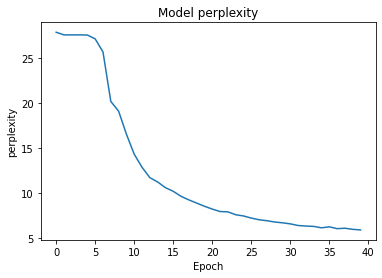

In [23]:
l = history.history["val_loss"]
exp_loss = tf.exp(l)
plt.plot(exp_loss)
plt.title('Model perplexity')
plt.ylabel('perplexity')
plt.xlabel('Epoch')

# Word RNN

# Preprocessing

In [3]:
f = open("data/shakespear_dataset.txt", "r")
text = f.read()
wordlist = []
wordlist = text.split()
dictionary = []
for i in wordlist:
    if i not in dictionary:
        dictionary.append(i)
#print(dictionary)

chunk_len = 15
print()
dataset = []
k = 0
for i in range(math.floor(len(wordlist)/chunk_len)):
    sentence = []
    for j in range(k,k+chunk_len):
        sentence.append(wordlist[j])
    k += chunk_len
    dataset.append(sentence)
#dataset = text.split()
print(dataset[0])


['First', 'Citizen:', 'Before', 'we', 'proceed', 'any', 'further,', 'hear', 'me', 'speak.', 'All:', 'Speak,', 'speak.', 'First', 'Citizen:']


In [235]:
# def indexing(sentence):
#     indexed = []
#     for word in sentence:
#         ind = dictionary.index(word)
#         indexed.append(ind)
#     return indexed

In [236]:
# new_dataset = []
# for sentence in dataset:
#     indexed_sentence = indexing(sentence)
#     new_dataset.append(indexed_sentence)

In [237]:
# def bow_embedder(sentence, vocab_len):
#     bow = np.zeros(vocab_len)
#     for index in sentence:
#         bow[index] += 1
#     return bow

In [238]:
# for i in range(len(new_dataset)):
#     sentence = new_dataset[i]
#     bow = bow_embedder(sentence, len(dictionary))
#     new_dataset[i] = bow

In [7]:
x = []
y = []
for sentence in dataset:
    x.append(np.array(sentence[:-1]))
    y.append(np.array(sentence[1:]))
x = np.array(x)
y = np.array(y)

In [8]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, train_size=0.6, random_state=None, shuffle=False, stratify=None)

# Model

In [9]:
rnn = keras.Sequential()
#rnn.add(keras.layers.Input(shape=(None, len(dictionary))))
rnn.add(keras.layers.Embedding(input_dim=len(dictionary), output_dim=64))
rnn.add(keras.layers.GRU(300, return_sequences=True))
rnn.add(keras.layers.LSTM(200, return_sequences=True))
rnn.add(keras.layers.Dense(len(dictionary), activation=keras.activations.softmax))
rnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 64)          1642816   
_________________________________________________________________
gru_1 (GRU)                  (None, None, 300)         329400    
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 200)         400800    
_________________________________________________________________
dense_1 (Dense)              (None, None, 25669)       5159469   
Total params: 7,532,485
Trainable params: 7,532,485
Non-trainable params: 0
_________________________________________________________________


In [10]:
opt = keras.optimizers.Adam(learning_rate=0.01)
loss_fn = keras.losses.CategoricalCrossentropy(from_logits=False)
rnn.compile(optimizer=opt, 
            loss=loss_fn,
            metrics=['accuracy'])

history = rnn.fit(x=x_train, y=y_train, batch_size=100, epochs=40, validation_split=0.4)

Epoch 1/40


ValueError: in user code:

    D:\anaconda\lib\site-packages\tensorflow\python\keras\engine\training.py:806 train_function  *
        return step_function(self, iterator)
    D:\anaconda\lib\site-packages\tensorflow\python\keras\engine\training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    D:\anaconda\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    D:\anaconda\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    D:\anaconda\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    D:\anaconda\lib\site-packages\tensorflow\python\keras\engine\training.py:789 run_step  **
        outputs = model.train_step(data)
    D:\anaconda\lib\site-packages\tensorflow\python\keras\engine\training.py:748 train_step
        loss = self.compiled_loss(
    D:\anaconda\lib\site-packages\tensorflow\python\keras\engine\compile_utils.py:204 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    D:\anaconda\lib\site-packages\tensorflow\python\keras\losses.py:149 __call__
        losses = ag_call(y_true, y_pred)
    D:\anaconda\lib\site-packages\tensorflow\python\keras\losses.py:253 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    D:\anaconda\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    D:\anaconda\lib\site-packages\tensorflow\python\keras\losses.py:1535 categorical_crossentropy
        return K.categorical_crossentropy(y_true, y_pred, from_logits=from_logits)
    D:\anaconda\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    D:\anaconda\lib\site-packages\tensorflow\python\keras\backend.py:4687 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    D:\anaconda\lib\site-packages\tensorflow\python\framework\tensor_shape.py:1134 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (None, 14) and (None, 14, 25669) are incompatible


# Test

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class RNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers):
        super(RNN, self).__init__()
        self.embedding = nn.Embedding(input_size, input_size)
        self.rnn = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input_seq, hidden_state):
        embedding = self.embedding(input_seq)
        print(embedding.size())
        output, hidden_state = self.rnn(embedding, hidden_state)
        output = self.decoder(output)
        return output, (hidden_state[0].detach(), hidden_state[1].detach())

In [29]:
########### Hyperparameters ###########
hidden_size = 512   # size of hidden state
seq_len = 100       # length of LSTM sequence
num_layers = 3      # num of layers in LSTM layer stack
lr = 0.002          # learning rate
epochs = 100        # max number of epochs
op_seq_len = 200    # total num of characters in output test sequence
load_chk = False    # load weights from save_path directory to continue training
save_path = "./preTrained/CharRNN_shakespeare.pth"
data_path = "data/shakespear_dataset.txt"
#######################################

# load the text file
data = open(data_path, 'r').read()
chars = sorted(list(set(data)))
data_size, vocab_size = len(data), len(chars)
print("----------------------------------------")
print("Data has {} characters, {} unique".format(data_size, vocab_size))
print("----------------------------------------")

----------------------------------------
Data has 1115393 characters, 64 unique
----------------------------------------


In [31]:
# char to index and index to char maps
char_to_ix = { ch:i for i,ch in enumerate(chars) }
ix_to_char = { i:ch for i,ch in enumerate(chars) }

# convert data from chars to indices
data = list(data)
for i, ch in enumerate(data):
    data[i] = char_to_ix[ch]

# data tensor on device
data = torch.tensor(data).to(device)
data = torch.unsqueeze(data, dim=1)

# model instance
rnn = RNN(vocab_size, vocab_size, hidden_size, num_layers).to(device)

# load checkpoint if True
if load_chk:
    rnn.load_state_dict(torch.load(save_path))
    print("Model loaded successfully !!")
    print("----------------------------------------")

# loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=lr)

KeyError: tensor([17], device='cuda:0')

In [18]:
# training loop
for i_epoch in range(1, epochs+1):

    # random starting point (1st 100 chars) from data to begin
    data_ptr = np.random.randint(100)
    n = 0
    running_loss = 0
    hidden_state = None

    while True:
        input_seq = data[data_ptr : data_ptr+seq_len]
        target_seq = data[data_ptr+1 : data_ptr+seq_len+1]

        # forward pass
        output, hidden_state = rnn(input_seq, hidden_state)

        # compute loss
        loss = loss_fn(torch.squeeze(output), torch.squeeze(target_seq))
        running_loss += loss.item()

        # compute gradients and take optimizer step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # update the data pointer
        data_ptr += seq_len
        n +=1

        # if at end of data : break
        if data_ptr + seq_len + 1 > data_size:
            break

    # print loss and save weights after every epoch
    print("Epoch: {0} \t Loss: {1:.8f}".format(i_epoch, running_loss/n))
    #torch.save(rnn.state_dict(), save_path)

    # sample / generate a text sequence after every epoch
    data_ptr = 0
    hidden_state = None

    # random character from data to begin
    rand_index = np.random.randint(data_size-1)
    input_seq = data[rand_index : rand_index+1]

    print("----------------------------------------")
    while True:
        # forward pass
        output, hidden_state = rnn(input_seq, hidden_state)

        # construct categorical distribution and sample a character
        output = F.softmax(torch.squeeze(output), dim=0)
        dist = Categorical(output)
        index = dist.sample()

        # print the sampled character
        print(ix_to_char[index.item()], end='')

        # next input is current output
        input_seq[0][0] = index.item()
        data_ptr += 1

        if data_ptr > op_seq_len:
            break

    print("\n----------------------------------------")

torch.Size([100, 1, 64])


KeyboardInterrupt: 